# Closed-loop replanning with JaxPlan.

This follow-up example provides another way to do closed-loop control in JaxPlan. Starting with the initial state of the system, optimize the action-fluents over a short lookahead horizon (e.g. 5 decision steps), then take the best immediate action from the plan and let the system evolve. Then repeat the process again, taking the best action from the new plan, and so on. This technique is called replanning in the planning literature, which is quite similar in flow to model-predictive control (MPC) where we obtain the dynamics model from the RDDL description.

Start by installing the required packages:

In [1]:
%pip install --quiet --upgrade pip
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym.git
%pip install --quiet git+https://github.com/pyrddlgym-project/rddlrepository.git
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym-jax.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the required packages:

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from IPython.display import Image
import os

import pyRDDLGym
from pyRDDLGym.core.visualizer.movie import MovieGenerator
from pyRDDLGym_jax.core.planner import JaxStraightLinePlan, JaxBackpropPlanner, JaxOnlineController, load_config_from_string

We will again optimize the stochastic Wildfire problem from IPPC 2014, noting again the use of the ``vectorized`` option:

In [3]:
env = pyRDDLGym.make('Wildfire_MDP_ippc2014', '1', vectorized=True)

The config file is similar to the open-loop examples, except we also specify the ``rollout_horizon`` parameter to indicate how far ahead we search during optimization:

In [4]:
config = """
[Model]
comparison_kwargs={'weight': 100}
rounding_kwargs={'weight': 100}
control_kwargs={'weight': 100}
[Optimizer]
method='JaxStraightLinePlan'
optimizer_kwargs={'learning_rate': 0.1}
rollout_horizon=5
[Training]
policy_hyperparams={'cut-out': 5.0, 'put-out': 5.0}
"""
planner_args, _, train_args = load_config_from_string(config)

We now initialize and run our controller. We will **set ``train_seconds`` to 1 to indicate that we want to optimize for 1 second per decision time step**:

In [5]:
planner = JaxBackpropPlanner(rddl=env.model, **planner_args)
agent = JaxOnlineController(planner, print_summary=False, train_seconds=1, **train_args)

Notice that no optimization is done before calling the ``evaluate`` function, because the replanning method will only optimize when it actually begins interacting with the environment, e.g. it observes the current state, finds the best action, executes it in the environment, then waits for the state to transition and begins again. 

Let's assign a visualizer so we can keep track of the behavior of the planner in real time. Then we just call ``evaluate()`` to actually do the planning:

      0 it /    -356.603119 train /    -115.781250 test /    -115.781250 best / 5 status:   0%|                                | 0/100 [00:02<?, ?it/s]
      1 it /     -84.883430 train /     -75.000000 test /     -75.000000 best / 5 status:   1%|▏                       | 1/100 [00:01<02:15,  1.37s/it]
    400 it /     -26.407290 train /     -55.359375 test /     -33.406250 best / 5 status: : 400it [00:01, 380.95it/s]                                  
    408 it /     -16.250628 train /      -4.750000 test /      -1.546875 best / 5 status: : 408it [00:01, 384.90it/s]                                  
    407 it /     -16.250628 train /      -4.750000 test /      -1.546875 best / 5 status: : 407it [00:01, 389.44it/s]                                  
    412 it /      -8.496055 train /      -3.703125 test /      -1.546875 best / 5 status: : 412it [00:01, 392.78it/s]                                  
    400 it /      -2.656929 train /      -3.875000 test /      -1.546875 best / 5 status

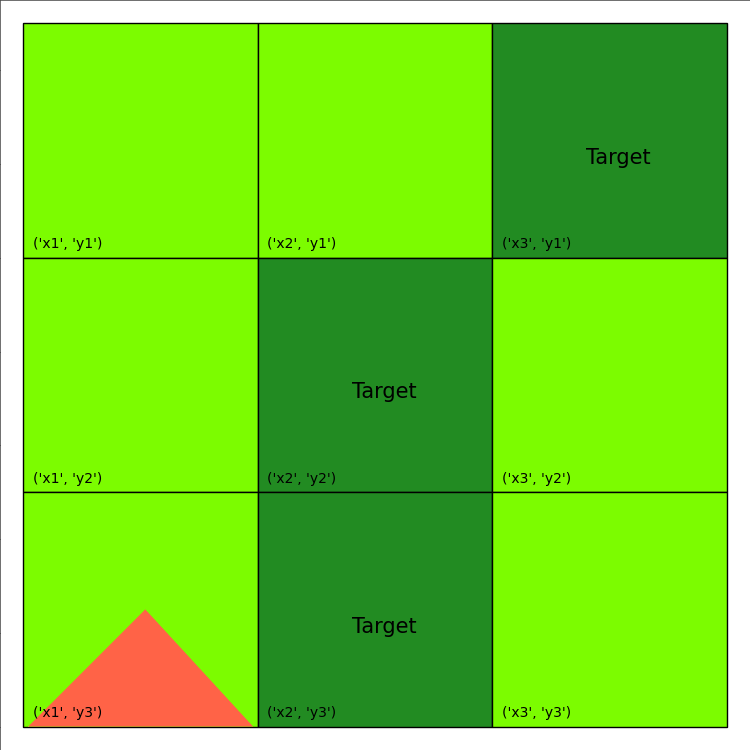

In [6]:
if not os.path.exists('frames'):
    os.makedirs('frames')
recorder = MovieGenerator("frames", "wildfire", max_frames=env.horizon)
env.set_visualizer(viz=None, movie_gen=recorder)

agent.evaluate(env, episodes=1, render=True)
env.close()
Image(filename='frames/wildfire_0.gif') 